## Raceline
This Jupyter Notebook combines the functionalities of center line extraction, map format conversion and raceline calculating

In [ ]:
import os
import yaml
import numpy as np
from PIL import Image
import networkx as nx
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt as edt

# --- User parameters ---
MAP_NAME = "bunch_of_sticks"        # Base filename (without extension) of your map
THRESHOLD = 0.175                   # Fraction of max EDT to threshold the "center" mask
SPUR_THRESH_M = 0.25                # Meters: prune any skeleton branch shorter than this
TRACK_WIDTH_MARGIN = 0.2            # Meters: subtract this from both left/right widths
DOWNSAMPLE_FACTOR = 1               # Keep every Nth waypoint (set >1 to thin points)

# --- 1. Load map image & YAML metadata ---
# Determine image path (.png or .pgm)
png_path = f"maps/{MAP_NAME}.png"
pgm_path = f"maps/{MAP_NAME}.pgm"
if os.path.exists(png_path):
    map_img_path = png_path
elif os.path.exists(pgm_path):
    map_img_path = pgm_path
else:
    raise FileNotFoundError(f"Neither {png_path} nor {pgm_path} found.")

# Load and flip vertically
img_pil = Image.open(map_img_path).convert('L')
raw_map_img = np.array(img_pil.transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)

# Load YAML
yaml_path = f"maps/{MAP_NAME}.yaml"
if not os.path.exists(yaml_path):
    raise FileNotFoundError(f"{yaml_path} not found.")
with open(yaml_path, 'r') as f:
    map_metadata = yaml.safe_load(f)
if 'resolution' not in map_metadata or 'origin' not in map_metadata:
    raise KeyError(f"YAML {yaml_path} must contain 'resolution' and 'origin'.")

map_resolution = map_metadata['resolution']
origin = map_metadata['origin']  # [orig_x, orig_y, orig_theta]

# --- 2. Binarize map & compute EDT ---
binary_map = raw_map_img.copy()
binary_map[binary_map <= 230.0] = 0
binary_map[binary_map > 230.0] = 1
binary_map = binary_map.astype(np.uint8)

dist_transform = edt(binary_map)

# --- 3. Extract skeleton via threshold + skeletonize ---
max_dist = dist_transform.max()
if max_dist == 0:
    raise ValueError("Distance transform is zero everywhere; map may be empty or invalid.")
centers_mask = dist_transform > (THRESHOLD * max_dist)
centerline_bool = skeletonize(centers_mask)

# --- 4. Build skeleton graph ---
# Get all skeleton pixel coords (y, x)
skel_pts = np.column_stack(np.nonzero(centerline_bool))
node_id = { (int(y), int(x)): idx for idx, (y, x) in enumerate(skel_pts) }

neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1),
                    ( 0, -1),          ( 0, 1),
                    ( 1, -1), ( 1, 0), ( 1, 1)]
edges = []
for idx, (y, x) in enumerate(skel_pts):
    for dy, dx in neighbor_offsets:
        ny, nx = int(y + dy), int(x + dx)
        if (ny, nx) in node_id:
            jdx = node_id[(ny, nx)]
            if jdx > idx:
                edges.append((idx, jdx))

import networkx as nx
G = nx.Graph()
G.add_nodes_from(range(len(skel_pts)))
G.add_edges_from(edges)

# --- 5. Prune spurs (short dead-end branches) ---
def prune_spurs(G_in, skel_pts, resolution, spur_thresh_m):
    Gp = G_in.copy()
    changed = True
    while changed:
        changed = False
        degrees = dict(Gp.degree())
        leaves = [n for n, d in degrees.items() if d == 1]
        to_remove = set()
        for leaf in leaves:
            path_nodes = [leaf]
            curr = leaf
            prev = None
            length_px = 0.0
            while True:
                nbrs = [n for n in Gp.neighbors(curr) if n != prev]
                if not nbrs:
                    break
                next_node = nbrs[0]
                y1, x1 = skel_pts[curr]
                y2, x2 = skel_pts[next_node]
                length_px += np.hypot(y2 - y1, x2 - x1)
                path_nodes.append(next_node)
                deg_next = Gp.degree(next_node)
                if deg_next != 2:
                    break
                prev, curr = curr, next_node
            length_m = length_px * resolution
            if length_m < spur_thresh_m:
                to_remove.update(path_nodes)
                changed = True
        if changed and to_remove:
            Gp.remove_nodes_from(to_remove)
    return Gp

G_pruned = prune_spurs(G, skel_pts, map_resolution, SPUR_THRESH_M)

# --- 6. Extract main path (loop or point-to-point) ---
def extract_main_path(Gp, skel_pts, resolution):
    cycles = nx.cycle_basis(Gp)
    if cycles:
        best_cycle = None
        best_len = 0.0
        for cyc in cycles:
            length_px = 0.0
            for i in range(len(cyc)):
                n1 = cyc[i]
                n2 = cyc[(i + 1) % len(cyc)]
                y1, x1 = skel_pts[n1]
                y2, x2 = skel_pts[n2]
                length_px += np.hypot(y2 - y1, x2 - x1)
            length_m = length_px * resolution
            if length_m > best_len:
                best_len = length_m
                best_cycle = cyc
        ordered = [best_cycle[0]]
        used = {best_cycle[0]}
        curr = best_cycle[0]
        while len(used) < len(best_cycle):
            for nbr in Gp.neighbors(curr):
                if nbr in best_cycle and nbr not in used:
                    ordered.append(nbr)
                    used.add(nbr)
                    curr = nbr
                    break
        return ordered
    degrees = dict(Gp.degree())
    leaves = [n for n, d in degrees.items() if d == 1]
    if len(leaves) < 2:
        return list(nx.nodes(Gp))
    def edge_wt(u, v, d):
        y1, x1 = skel_pts[u]
        y2, x2 = skel_pts[v]
        return np.hypot(y2 - y1, x2 - x1)
    best_pair = None
    best_dist = 0.0
    for i, leaf in enumerate(leaves):
        dist_dict = nx.single_source_dijkstra_path_length(Gp, leaf, weight=edge_wt)
        for other in leaves[i+1:]:
            d = dist_dict.get(other, np.inf)
            if d > best_dist:
                best_dist = d
                best_pair = (leaf, other)
    if best_pair is None:
        return list(nx.nodes(Gp))
    start_node, end_node = best_pair
    path_nodes = nx.shortest_path(Gp, source=start_node, target=end_node, weight=edge_wt)
    return path_nodes

ordered_nodes = extract_main_path(G_pruned, skel_pts, map_resolution)

# --- 7. Convert to world coords & apply margin ---
waypoints_px = np.array([[skel_pts[n][1], skel_pts[n][0]] for n in ordered_nodes], dtype=np.float64)
track_widths_px = np.array([
    [
        dist_transform[int(skel_pts[n][0]), int(skel_pts[n][1])],
        dist_transform[int(skel_pts[n][0]), int(skel_pts[n][1])]
    ]
    for n in ordered_nodes
], dtype=np.float64)

if DOWNSAMPLE_FACTOR > 1:
    waypoints_px = waypoints_px[::DOWNSAMPLE_FACTOR]
    track_widths_px = track_widths_px[::DOWNSAMPLE_FACTOR]

waypoints_m = waypoints_px * map_resolution
orig_x, orig_y = origin[0], origin[1]
waypoints_m[:, 0] += orig_x
waypoints_m[:, 1] += orig_y

track_widths_m = track_widths_px * map_resolution
track_widths_m[:, 0] = np.maximum(track_widths_m[:, 0] - TRACK_WIDTH_MARGIN, 0.0)
track_widths_m[:, 1] = np.maximum(track_widths_m[:, 1] - TRACK_WIDTH_MARGIN, 0.0)

final_data = np.hstack([waypoints_m, track_widths_m])

# --- 8. Save to CSV ---
os.makedirs("inputs/tracks", exist_ok=True)
out_path = f"inputs/tracks/{MAP_NAME}.csv"
header = "x_m,y_m,w_tr_right_m,w_tr_left_m"
np.savetxt(out_path, final_data, fmt="%.4f", delimiter=",", header=header)
print(f"Saved {final_data.shape[0]} centerline points to {out_path}")

Saved 1624 centerline points to inputs/tracks/bunch_of_sticks.csv


### Sanity Check

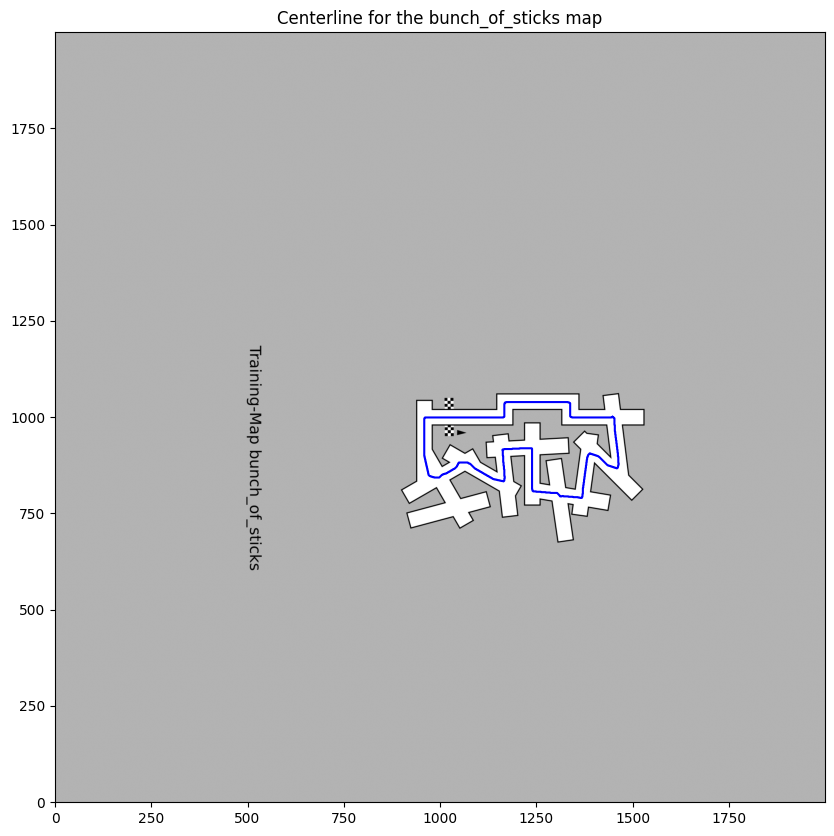

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from PIL import Image
import os
import pandas as pd

if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"maps/{MAP_NAME}.yaml"
map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
map_img = map_img.astype(np.float64)

# load map yaml
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

raw_data = pd.read_csv(f"inputs/tracks/{MAP_NAME}.csv")
x = raw_data["# x_m"].values
y = raw_data["y_m"].values
wr = raw_data["w_tr_right_m"].values
wl = raw_data["w_tr_left_m"].values

x -= orig_x
y -= orig_y

x /= map_resolution
y /= map_resolution

plt.figure(figsize=(10, 10))
plt.title(f"Centerline for the {MAP_NAME} map")
plt.imshow(map_img, cmap="gray", origin="lower")
plt.plot(x,y, color='blue')

### Run the Script to Create a Raceline

Spline approximation: mean deviation 0.07m, maximum deviation 0.36m
Track shape: (267, 4)
Horizon: 10
Solver runtime opt_shortest_path: 0.031s
INFO: Estimated laptime: 21.12s


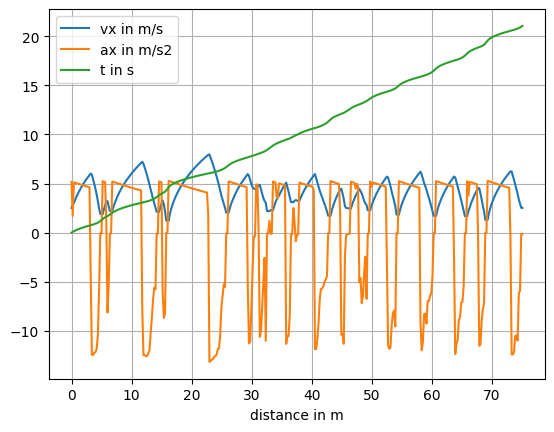

INFO: Runtime from import to final trajectory was 1.67s
INFO: Finished export of trajectory: 20:34:44


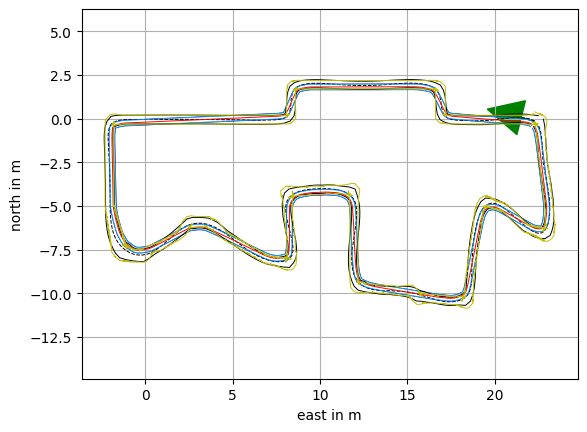

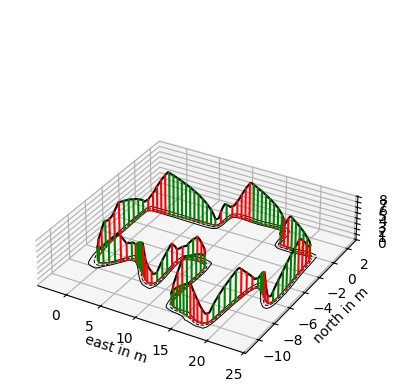

In [3]:
OPT_TYPE = "shortest_path" # Options: "shortest_path", "mincurv", "mincurv_iqp", "mintime"

%matplotlib inline
import runpy, sys

# If you are satisfied with the center line, you can run the main script to get the optimized raceline
x = input("Create raceline? (y/n):")
if x.lower() == "y":
    sys.argv = ["main_globaltraj_f110.py", "--map_name", MAP_NAME, "--opt_type", OPT_TYPE]
    runpy.run_module("main_globaltraj_f110", run_name="__main__")
else:
    print("Exiting without creating a raceline")
    
# If you see the "at least one pair of normals is crossed" error, go to the /trajectory_planning_helpers/calc_splines.py and increase the DOWNSCALE (line 4)
# By default it is set to 3.0, which is usually enough, but if you have a very complex track, you may need to increase it
# The original repo by the researchers at TU Munich was designed for real cars, so we had to shorten the normals to use it for F1Tenth

### Visualize Raceline

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import numpy as np
import os
from PIL import Image
import glob
%matplotlib inline

csv_files = glob.glob(f'outputs/{MAP_NAME}/*.csv', recursive=True)
csv_files = sorted(csv_files)
raw_data = pd.read_csv(csv_files[-1], header=None, sep=',')

# Overlay the racetrack on the map
# load map yaml
if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"maps/{MAP_NAME}.yaml"
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = raw_data.copy()
transformed_data -= np.array([orig_x, orig_y, 0])
transformed_data.iloc[:, :2] /= map_resolution

raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

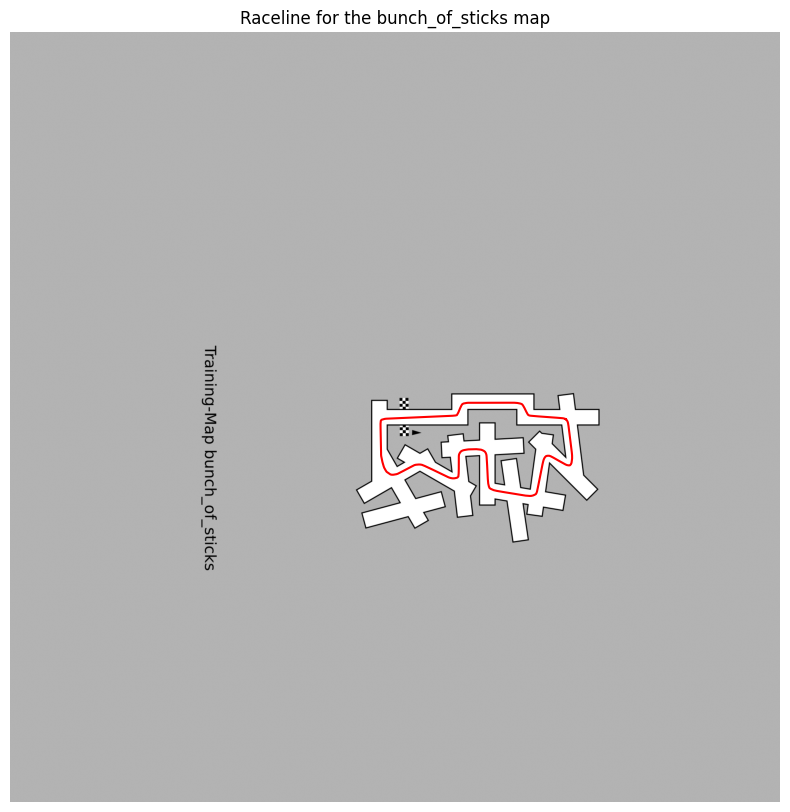

In [5]:
plt.figure(figsize=(10,10))
plt.title(f"Raceline for the {MAP_NAME} map")
plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.plot(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], color='red')
# Save image without the axis
plt.axis('off')
plt.savefig(f"outputs/{MAP_NAME}_raceline.png", bbox_inches='tight', pad_inches=0)
plt.imshow(raw_map_img, cmap='gray', origin='lower')

(np.float64(-0.5), np.float64(1999.5), np.float64(-0.5), np.float64(1999.5))

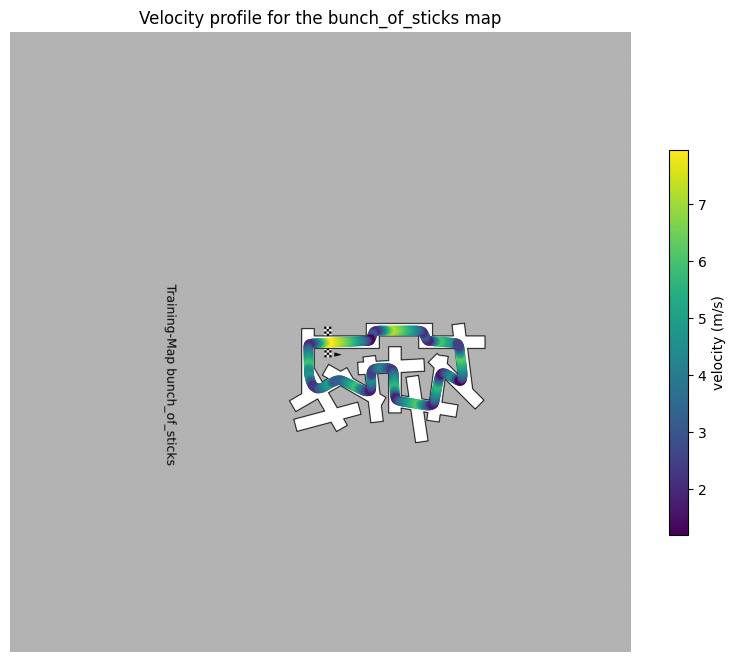

In [6]:
plt.figure(figsize=(10,10))
plt.title(f"Velocity profile for the {MAP_NAME} map")
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.iloc[:, 2])
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('velocity (m/s)')

plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.axis('off')